# Topic 36: Recommendation Systems

- 06/11/21
- onl01-dtsc-022221FT


## Questions:

- In [this lab](https://github.com/learn-co-curriculum/dsc-implementing-recommender-systems-lab/tree/solution), we do a gridsearch to figure out how to optimize our SVD factorization, but I don’t understand why we are using KNNBasic and Baseline as well as cross-validating the data?  

## Additional Resources

### Surpise's Baseline Models

- **[Using Surpise's Baseline model](https://buomsoo-kim.github.io/recommender%20systems/2020/07/18/Recommender-systems-collab-filtering-3.md/)**
    - [Follow-Up Post comparing baseline to KNN](https://buomsoo-kim.github.io/recommender%20systems/2020/09/06/Recommender-systems-collab-filtering-8.md/)

### Evaluating Recommendation Systems

- Evaluating Recommendation Systems: 
    - https://medium.com/the-owl/evaluating-recommender-systems-749570354976

# Recommendation Systems

We have seen how Recommender/Recommendation Systems have played an integral parts in the success of Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos), etc.  For Amazon, these systems bring more than 30% of their total revenues. For Netflix service, 75% of movies that people watch are based on some sort of recommendation.

> The goal of Recommendation Systems is to find what is likely to be of interest to the user. This enables organizations to offer a high level of personalization and customer-tailored services.

## Three Main Types

- non-personalized
- content-based
- collaborative filtering

### Non-Personalized Recommendations

![screenshot of youtube's homepage](img/youtube-nonpersonalizedrecommendations.png)

YouTube is notorious for putting non-personalized content on their homepage (although they tailor recommendations in other places)

These recommendations are based purely on the popularity of the item!

#### Advantages
- Super easy (computationally and for the user to understand)
- Items are usually popular for a reason
- No cold-start issue

#### Disadvantages
- Not personalized
- New items won’t gain traction

## Content-Based

![screenshot found online of someone's 'made for you' recommendations from spotify](img/spotify-contentrecommendations.png)

[Image Source](https://www.howtogeek.com/393291/already-a-spotify-fan-here-are-6-new-features-you-might-have-missed/)

Content-based recommendations are based on the properties/attributes of the items, where the items you've rated highly (or, in Spotify's case, listened to recently or often) are then compared against the properties/attributes of other items, and those items are then recommended if they're considered 'similar'.

What items are 'similar'? Depends on your similarity metric:

![similarity metrics comparison](img/similaritymetrics.png)

[Image Source: "What Similarity Metric Should You Use for Your Recommendation System?](https://medium.com/bag-of-words/what-similarity-metric-should-you-use-for-your-recommendation-system-b45eb7e6ebd0) <- useful reading!

Those are just 3 examples, there are others (Jaccard index, Euclidian similarity) - but the point is you take some mathematical understanding of the items and find which ones are 'nearby' in some sense.

#### Advantages:
- Easy and transparent
- No cold start issue
- Recommend items to users with unique tastes

#### Disadvantages:
- Requires some type of tagging of items
- Overspecialization to certain types of items

## Collaborative Filtering

![collaborative filtering utility matrix example](img/collaborativefiltering.png)

[Image Source](https://www.incubegroup.com/blog/recommender-system-for-private-banking/)

Use both User and Item data! Use past behavior of many users (how they've rated many items) to find similarities either between users or between items (either user-based or item-based) to recommend new things.

We build a Utility/Rating Matrix to capture many users' ratings of many different items - a matrix that, in practice, tends to be quite _sparse_ (see all the blanks in just this tiny example above).

Then, we use **_MATH_** (namely, matrix factorization) to fill in those blanks, based upon similar users' ratings of similar items.

More specifically, it finds factor matrices which result in the ratings it has - decomposing the actual Utility Matrix into component pieces that explain it. These component pieces, matrices themselves, can be thought of as 'latent' or 'inherent' features of the items and users! The math then comes in, as we calculate the dot products in order to arrive at our predicted ratings.'

<img src="img/matrixfactorization.png" alt="matrix factorization image, showing the factor matrices" width=700>

[Image Source](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

A bit more on Matrix Factorization, from Google's Recommendations Systems crash course: https://developers.google.com/machine-learning/recommendation/collaborative/matrix

#### Advantages:
- Personalized. You’re special!

#### Disadvantages:
- Can require a lot of computation, especially as these matrices get larger
- Cold start: need to have a lot of ratings to be worthwhile
- Popularity Bias: biased towards items that are popular. May not capture people’s unique tastes.

Matrix factorization methods include Singular Value Decomposition (SVD) and Alternating Least Squares (ALS)

I'll note that there are differences between _explicit_ and _implicit_ ratings.

- **_Explicit_** data is gathered from users when we ask a user to rate an item on some scale
    - Pros: concrete rating system, can assume users actually feel the way they input and thus can extrapolate from those preferences
    - Cons: not all users might input their preferences
- **_Implicit_** data is gathered from users without their direct input - a system logs the actions of a user
    - Pros: Easier to collect automatically, thus have more data from more users without those users needing to go through extra steps
    - Cons: More difficult to work with - how do we know what actions imply preference?
    
[insert comment about y'all filling out surveys here]

[Resource](https://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/collaborativefiltering.html#:~:text=Implicit%20Data%20Collection,system%20has%20to%20collect%20data.&text=Explicit%20data%20gathering%20is%20easy,data%20to%20predict%20future%20ratings.)

> #### And now, in code!

## Recommendation Systems with `Surprise`

### Reading in the data and simple EDA

#### Data Source:

https://www.kaggle.com/rounakbanik/the-movies-dataset

In [1]:
# Import libraries, round 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
# load in data and check it out
df = pd.read_csv('data/ratings.csv') 
print(df.shape) 
df.head(10) 

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
# Can also get the data straight from the surprise library we'll be using
# from surprise import Dataset
# data = Dataset.load_builtin('ml-100k')
# df = pd.read_csv('~/.surprise_data/ml-100k/ml-100k/u.data',
#             sep='\t', header=None)
# df = df.rename(columns={0: 'user', 1: 'item', 2: 'rating', 3: 'timestamp'})

### Ratings

In [4]:
# check value_counts
ratings = df['rating'].value_counts()
ratings

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

In [5]:
ratings_sorted = dict(zip(ratings.index, ratings))

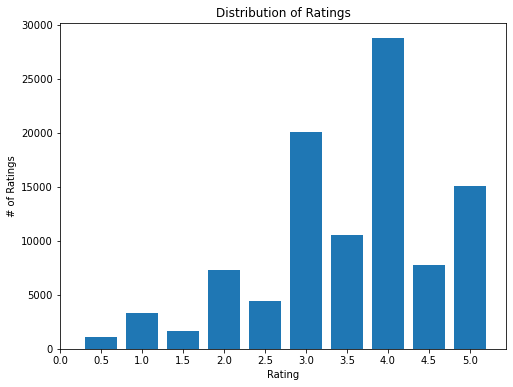

In [6]:
# plot distribution in matplotlib
plt.figure(figsize=(8,6))
plt.bar(ratings_sorted.keys(), ratings_sorted.values(), width=.4)
plt.xticks(np.arange(0, 5.1, step=0.5))
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

### Users

In [7]:
print("Number of users: ", df.userId.nunique()) 
print("Average Number of Reviews per User: ", df.shape[0]/df.userId.nunique())

Number of users:  671
Average Number of Reviews per User:  149.03725782414307


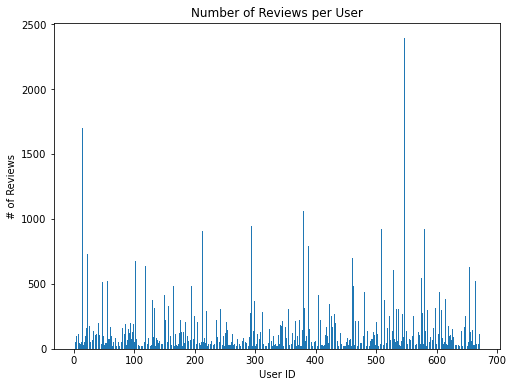

In [8]:
ratings_per_user = df['userId'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))

plt.figure(figsize=(8,6))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user])
plt.xlabel("User ID")
plt.ylabel("# of Reviews")
plt.title("Number of Reviews per User")
plt.show()

### Movies

In [9]:
print("Number of movies: ", df.movieId.nunique())
print("Average Number of Reviews per Movie: ", df.shape[0]/df.movieId.nunique())

Number of movies:  9066
Average Number of Reviews per Movie:  11.030664019413193


In [10]:
# the movie IDs with the most ratings
df['movieId'].value_counts()[:10]

356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
Name: movieId, dtype: int64

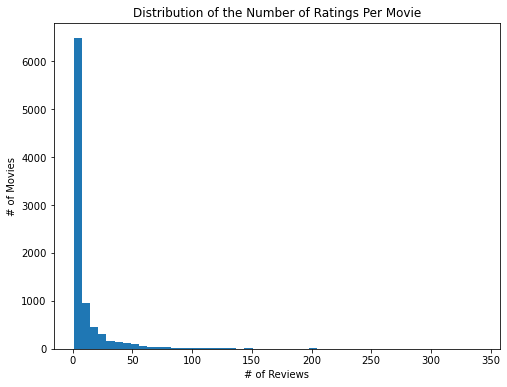

In [11]:
ratings_per_movie = df['movieId'].value_counts()

plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("# of Reviews")
plt.ylabel("# of Movies")
plt.title("Distribution of the Number of Ratings Per Movie")
plt.show()

## Singular Value Decomposition using Surprise

Written by Yish, thanks <3

One of the easiest libraries to use for recommendation systems is Surprise, which stands for **Simple Python Recommendation System Engine**. Here, we'll code a recommendation system using the Surprise Library's Singular Value Decomposition (SVD) algorithm.

To read more about Surprise's SVD implementation, and its hyperparameters:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [12]:
# If you need the surprise library
# !pip install surprise

In [13]:
# Import libraries, round 2
from surprise import Dataset, Reader
from surprise import SVD, KNNBaseline,KNNBasic,BaselineOnly, KNNWithMeans
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate, train_test_split

In [14]:
# for Surprise, we only need three columns from the dataset
data = df[['userId', 'movieId', 'rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

# train-test-split
trainset, testset = train_test_split(data, test_size=.2)

In [15]:
# instantiate SVD and fit the trainset
svd = SVD() # default values
svd.fit(trainset)

In [16]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8986


0.8986201926642174

### Making Predictions

In [17]:
# taking a look at the first 10 rows of our test set
predictions[:10]

[Prediction(uid=608, iid=1809, r_ui=5.0, est=3.8773070767381212, details={'was_impossible': False}),
 Prediction(uid=607, iid=1917, r_ui=3.0, est=3.3394221108489024, details={'was_impossible': False}),
 Prediction(uid=128, iid=4992, r_ui=4.0, est=4.017324009941622, details={'was_impossible': False}),
 Prediction(uid=627, iid=6365, r_ui=2.5, est=2.6183998133808535, details={'was_impossible': False}),
 Prediction(uid=247, iid=2469, r_ui=2.0, est=3.4996164180817044, details={'was_impossible': False}),
 Prediction(uid=464, iid=260, r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid=463, iid=2671, r_ui=3.0, est=3.3979837018093844, details={'was_impossible': False}),
 Prediction(uid=283, iid=8973, r_ui=3.5, est=3.3465548738056894, details={'was_impossible': False}),
 Prediction(uid=348, iid=293, r_ui=4.0, est=4.098387931133252, details={'was_impossible': False}),
 Prediction(uid=159, iid=1080, r_ui=3.5, est=3.688175380064934, details={'was_impossible': False})]

In [18]:
print("Number of users: ", df.userId.nunique()) 
print("Number of movies: ", df.movieId.nunique()) 

Number of users:  671
Number of movies:  9066


In [19]:
user = 5
item = 141
svd.predict(user, item)

Prediction(uid=5, iid=141, r_ui=None, est=3.845532397862641, details={'was_impossible': False})

## More Models? More Models!

Surprise has some basic algorithms - like `BaselineOnly`, which predicts a baseline estimate for a given user an item.

https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

- **[Blog Post: Using Surpise's Baseline model](https://buomsoo-kim.github.io/recommender%20systems/2020/07/18/Recommender-systems-collab-filtering-3.md/)**

In [20]:
from surprise import BaselineOnly

In [21]:
# showcasing the cross_validate function as well 
cross_validate(BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9005  0.8990  0.8898  0.8853  0.8895  0.8928  0.0059  
MAE (testset)     0.6949  0.6935  0.6877  0.6863  0.6878  0.6900  0.0035  
Fit time          0.24    0.25    0.24    0.25    0.25    0.25    0.00    
Test time         0.11    0.16    0.09    0.09    0.16    0.12    0.03    


{'test_rmse': array([0.90051219, 0.898986  , 0.88982632, 0.88527651, 0.88949367]),
 'test_mae': array([0.69488463, 0.69349274, 0.68765508, 0.68633098, 0.68782191]),
 'fit_time': (0.2424328327178955,
  0.24697017669677734,
  0.24274206161499023,
  0.2520568370819092,
  0.24761009216308594),
 'test_time': (0.10674285888671875,
  0.15937018394470215,
  0.08797478675842285,
  0.0859980583190918,
  0.1602649688720703)}

#### KNN

Plus there are always neighbors!

In [22]:
from surprise import KNNBasic, NMF, SVD

In [23]:
KNN_model = KNNBasic().fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [24]:
# find the nearest neighbors to an item
KNN_model.get_neighbors(iid=item, k=1) # using same item as earlier

[196]

#### Comparing Mdoels

In [25]:
model_knn = KNNBasic().fit(trainset)

model_svd = SVD().fit(trainset)

model_nmf = NMF().fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
results = {}
results['knn'] = {'mae':accuracy.mae(model_knn.test(testset)),
                  'rmse':accuracy.rmse(model_knn.test(testset))}

MAE:  0.7479
RMSE: 0.9712


In [27]:
results['svd'] = {'mae':accuracy.mae(model_svd.test(testset)),
                  'rmse':accuracy.rmse(model_svd.test(testset))}

MAE:  0.6894
RMSE: 0.8957


In [28]:
results['nmf'] = {'mae':accuracy.mae(model_nmf.test(testset)),
                  'rmse':accuracy.rmse(model_nmf.test(testset))}

MAE:  0.7277
RMSE: 0.9488


In [29]:
import pandas as pd
pd.DataFrame(results).T.style.background_gradient().format('{:.2f}')

,mae,rmse
knn,0.75,0.97
svd,0.69,0.90
nmf,0.73,0.95
